In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc

In [214]:
train_df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

sample = pd.read_csv("sample_submission.csv")   

train_df['dataset_type'] = 'train'
test["price"] = None
test['dataset_type'] = 'test'

train = pd.concat([train_df, test], ignore_index=True)

In [215]:
display(train.info())
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314223 entries, 0 to 314222
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            314223 non-null  int64 
 1   brand         314223 non-null  object
 2   model         314223 non-null  object
 3   model_year    314223 non-null  int64 
 4   milage        314223 non-null  int64 
 5   fuel_type     305757 non-null  object
 6   engine        314223 non-null  object
 7   transmission  314223 non-null  object
 8   ext_col       314223 non-null  object
 9   int_col       314223 non-null  object
 10  accident      310139 non-null  object
 11  clean_title   278565 non-null  object
 12  price         188533 non-null  object
 13  dataset_type  314223 non-null  object
dtypes: int64(3), object(11)
memory usage: 33.6+ MB


None

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,dataset_type
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,train
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,train
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,train
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,train
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,train


model with nan values => clean_title, accident, fuel_type

In [216]:
for nan_col in ["fuel_type", "clean_title", "accident"]:
    print(f"column {nan_col} has {(len(train[train[nan_col].isnull()])/len(train)) * 100 :0.2f}% of nan values")

column fuel_type has 2.69% of nan values
column clean_title has 11.35% of nan values
column accident has 1.30% of nan values


analyzing object columns

In [217]:
for col in train.columns:
    if train[col].dtype == "object":
        print(f"{col} has {train[col].nunique()} unique values")

brand has 57 unique values
model has 1898 unique values
fuel_type has 7 unique values
engine has 1118 unique values
transmission has 52 unique values
ext_col has 319 unique values
int_col has 156 unique values
accident has 2 unique values
clean_title has 1 unique values
price has 1569 unique values
dataset_type has 2 unique values


for object columns that has less than 10 unique values, probably we can do one hot encoding

since we know that clean_title only has two values, which is Yes or nan, we can just change nan into a False, and considered it as no

In [218]:
train["clean_title"] = train["clean_title"].fillna("No")
train["clean_title"] = train["clean_title"].replace(["Yes", "No"], [1, 0]).astype(bool)

/var/folders/c1/g_qgswp92pn07w79flqmp52m0000gn/T/ipykernel_78694/4072583004.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train["clean_title"] = train["clean_title"].replace(["Yes", "No"], [1, 0]).astype(bool)


accident has three values, none reported, at least one, and nan. We can do one hot encoding with this

In [219]:
train["accident"] = train["accident"].fillna("Not given")
train = pd.get_dummies(train, columns = ["accident"])

for ext_col and int_col, since they are just "color" we can just divide it into some color that similar to its color. For instance, oxford white will be categorized as white

In [220]:
list_color_ext = ["black", "white", "gray", "silver", "blue", "red", "green", "gold", "brown", "orange", "beige", "yellow", "metallic"]
list_color_ints = ["black", "white", "gray", "silver", "blue", "red", "green", "gold", "brown", "orange", "beige", "ebony"]

# Fixing the loop for external colors
for ext in list_color_ext:
    train[f"ext_{ext}"] = train["ext_col"].apply(lambda x: ext in str(x).lower())

# Fixing the loop for internal colors
for ints in list_color_ints:
    train[f"int_{ints}"] = train["int_col"].apply(lambda x: ints in str(x).lower())

In [222]:
train["brand"].value_counts().to_csv("brand_count.csv")

For brand, what I think that I can do is that do one hot encoding? for value > 1000, and just put "others" for the rest

In [223]:
train["model"].value_counts().to_csv("model_count.csv")

since there are a lot of model, I just assume that it might not be that important because I still have no idea what to do with this columns 


In [224]:
train = train.drop(columns=["model", "ext_col", "int_col"])

In [225]:
value_counts = train['brand'].value_counts()
threshold = 2000
train['brand_modified'] = train['brand'].apply(lambda x: x if value_counts[x] >= threshold else 'Others')
train = pd.get_dummies(train, columns = ["brand_modified"])

In [226]:
train = train.drop(columns="brand")

In [227]:
train = train.drop(columns="id")

In [228]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314223 entries, 0 to 314222
Data columns (total 63 columns):
 #   Column                                           Non-Null Count   Dtype 
---  ------                                           --------------   ----- 
 0   model_year                                       314223 non-null  int64 
 1   milage                                           314223 non-null  int64 
 2   fuel_type                                        305757 non-null  object
 3   engine                                           314223 non-null  object
 4   transmission                                     314223 non-null  object
 5   clean_title                                      314223 non-null  bool  
 6   price                                            188533 non-null  object
 7   dataset_type                                     314223 non-null  object
 8   accident_At least 1 accident or damage reported  314223 non-null  bool  
 9   accident_None reported    

In [229]:
train["fuel_type"].value_counts().to_csv("fuel_type_count.csv")

In [230]:
train["fuel_type"] = train["fuel_type"].fillna("–")

In [231]:
train = pd.get_dummies(train, columns = ["fuel_type"])

In [232]:
train["engine"].value_counts().to_csv("engine_count.csv")

In [233]:
train["engine"].to_csv("engine.csv")

In [234]:
import re # from chatgpt

# Define regex patterns to capture various parts of the engine description
def extract_engine_details(engine_str):
    # Regex to capture horsepower (e.g., '355.0HP')
    horsepower_match = re.search(r'(\d+\.?\d*)HP', engine_str)
    horsepower = horsepower_match.group(1) if horsepower_match else None

    # Regex to capture engine size (e.g., '5.3L')
    engine_size_match = re.search(r'(\d+\.?\d*)L', engine_str)
    engine_size = engine_size_match.group(1) if engine_size_match else None

    # Regex to capture cylinder count (e.g., '8 Cylinder')
    cylinder_match = re.search(r'(\d+) Cylinder', engine_str)
    cylinder_count = cylinder_match.group(1) if cylinder_match else None

    return pd.Series([horsepower, engine_size, cylinder_count])

# Apply the function to the DataFrame to create new columns
train[['Horsepower', 'Engine_Size', 'Cylinder_Count']] = train['engine'].apply(extract_engine_details)

# Display the updated DataFrame with new columns

In [235]:
train["transmission"].value_counts()

transmission
A/T                                                   83036
8-Speed A/T                                           34586
Transmission w/Dual Shift Mode                        32079
6-Speed A/T                                           30105
6-Speed M/T                                           19863
7-Speed A/T                                           18498
Automatic                                             17866
8-Speed Automatic                                     13977
10-Speed A/T                                          13347
9-Speed A/T                                            6450
5-Speed A/T                                            5458
10-Speed Automatic                                     5268
6-Speed Automatic                                      4690
4-Speed A/T                                            4212
5-Speed M/T                                            4048
9-Speed Automatic                                      3878
CVT Transmission           

In [236]:
# Let's define a function to extract transmission details # chat gpt again
def extract_transmission_details(transmission_str):
    # Regex to capture number of speeds (e.g., '8-Speed', '6-Speed')
    speed_match = re.search(r'(\d+)-Speed', transmission_str)
    speed = speed_match.group(1) if speed_match else None

    # Regex to capture transmission type (e.g., 'A/T', 'M/T', 'Automatic', 'Manual', 'CVT')
    transmission_type_match = re.search(r'(A/T|M/T|CVT|Automatic|Manual)', transmission_str)
    transmission_type = transmission_type_match.group(1) if transmission_type_match else None

    # Check for special modes or features (e.g., 'Dual Shift Mode', 'Overdrive')
    special_mode = None
    if 'Dual Shift Mode' in transmission_str:
        special_mode = 'Dual Shift Mode'
    elif 'Overdrive' in transmission_str:
        special_mode = 'Overdrive'
    elif 'Auto-Shift' in transmission_str:
        special_mode = 'Auto-Shift'
    
    return pd.Series([speed, transmission_type, special_mode])

# Example DataFrame with the transmission data

# Apply the regex extraction function to the transmission column
train[['Speed', 'Transmission_Type', 'Special_Mode']] = train['transmission'].apply(extract_transmission_details)

In [237]:
train = train.drop(columns=["engine", "transmission"])

In [238]:
list_col = []

for col in train.columns:
    if train[col].dtype == "object":
        list_col.append(col)

list_col

['price',
 'dataset_type',
 'Horsepower',
 'Engine_Size',
 'Cylinder_Count',
 'Speed',
 'Transmission_Type',
 'Special_Mode']

In [239]:
train["Horsepower"] = train["Horsepower"].fillna(0).astype(float)

In [240]:
train["Engine_Size"] = train["Engine_Size"].fillna(0).astype(float)

In [241]:
train["Cylinder_Count"] = train["Cylinder_Count"].fillna(0).astype(int)

In [242]:
train["Speed"] = train["Speed"].fillna(0).astype(int)

In [243]:
train["Transmission_Type"] = train["Transmission_Type"].fillna("not_given")
train["Special_Mode"] = train["Special_Mode"].fillna("not_given")

train = pd.get_dummies(train, columns = ["Transmission_Type"])
train = pd.get_dummies(train, columns = ["Special_Mode"])

In [244]:
df = train[train["dataset_type"] == "train"]

In [245]:
random_state = 13

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

models = {
    "xgb":XGBRegressor(random_state=random_state),
    "catboost":CatBoostRegressor(random_state=random_state),
    "lgbm":LGBMRegressor(random_state=random_state)
}

X = df.drop(columns=["price", "dataset_type"])
y = df["price"].astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Set the number of folds for KFold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Create a dictionary to store the RMSE values for each model
rmse_scores = {name: [] for name in models.keys()}

# Loop over each model
for model_name, model in models.items():
    print(f"Evaluating model: {model_name}")
    
    fold_rmse = []
    
    # KFold cross-validation
    for train_index, val_index in kf.split(X):
        # Split data into train and validation sets for this fold
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the validation set
        y_pred = model.predict(X_val)
        
        # Calculate RMSE for this fold
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        fold_rmse.append(rmse)
    
    # Store the mean RMSE for this model across all folds
    rmse_scores[model_name] = np.mean(fold_rmse)
    print(f"Model: {model_name}, Mean RMSE: {rmse_scores[model_name]:.4f}")

# Display the final RMSE scores for each model
print("\nFinal RMSE scores for each model:")
for model_name, rmse in rmse_scores.items():
    print(f"{model_name}: {rmse:.4f}")



Evaluating model: xgb
Model: xgb, Mean RMSE: 76076.9213
Evaluating model: catboost
Learning rate set to 0.090444
0:	learn: 77255.1933511	total: 19ms	remaining: 19s
1:	learn: 76537.0919324	total: 27.4ms	remaining: 13.7s
2:	learn: 75944.4647209	total: 34.9ms	remaining: 11.6s
3:	learn: 75452.5537270	total: 43ms	remaining: 10.7s
4:	learn: 74992.4732361	total: 50.4ms	remaining: 10s
5:	learn: 74625.2971217	total: 58.1ms	remaining: 9.63s
6:	learn: 74309.5214225	total: 65.5ms	remaining: 9.29s
7:	learn: 74055.1824267	total: 73.4ms	remaining: 9.1s
8:	learn: 73824.2684884	total: 81.3ms	remaining: 8.95s
9:	learn: 73588.4911918	total: 90.3ms	remaining: 8.94s
10:	learn: 73397.5965030	total: 98.2ms	remaining: 8.83s
11:	learn: 73241.2780637	total: 106ms	remaining: 8.75s
12:	learn: 73088.8594694	total: 115ms	remaining: 8.75s
13:	learn: 72978.2962136	total: 123ms	remaining: 8.65s
14:	learn: 72865.8607460	total: 131ms	remaining: 8.62s
15:	learn: 72776.9789559	total: 139ms	remaining: 8.56s
16:	learn: 7269

entahlah bang, masih banyak yang salah pasti, baru engineer data doang soalnya

In [246]:
chosen_model = models["lgbm"]

test_df = train[train["dataset_type"] == 'test']
test_df = test_df.drop(columns=["dataset_type", "price"])

preds = model.predict(test_df)

sample["price"] = preds
sample.to_csv("second_submission.csv", index=False)

In [247]:
tr = train[train["dataset_type"] == "train"].drop(columns="dataset_type")
tr

,model_year,milage,clean_title,price,accident_At least 1 accident or damage reported,accident_None reported,accident_Not given,ext_black,ext_white,ext_gray,...,Transmission_Type_A/T,Transmission_Type_Automatic,Transmission_Type_CVT,Transmission_Type_M/T,Transmission_Type_Manual,Transmission_Type_not_given,Special_Mode_Auto-Shift,Special_Mode_Dual Shift Mode,Special_Mode_Overdrive,Special_Mode_not_given
0,2007,213000,True,4200,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
1,2002,143250,True,4999,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
2,2002,136731,True,13900,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
3,2017,19500,True,45000,False,True,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
4,2021,7388,True,97500,False,True,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,2017,49000,True,27500,False,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
188529,2018,28600,True,30000,True,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
188530,2021,13650,True,86900,False,True,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
188531,2022,13895,False,84900,False,True,False,False,False,True,...,False,True,False,False,False,False,False,False,False,True


In [248]:
tr.isna().any().any()

False

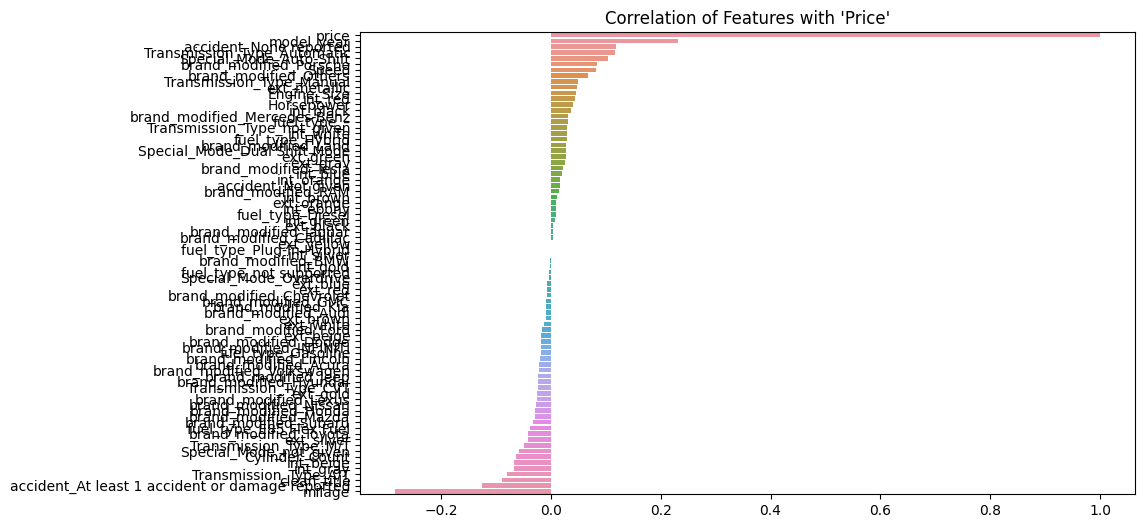

In [249]:
corr_mat = tr.corr()
price_corr = corr_mat["price"].sort_values(ascending=False)
price_corr.to_csv("price_corr.csv")

plt.figure(figsize=(10, 6))
sns.barplot(x=price_corr.values, y=price_corr.index)
plt.title("Correlation of Features with 'Price'")
plt.show()

                   Feature  Importance
1                   milage         743
65              Horsepower         370
0               model_year         362
66             Engine_Size         293
68                   Speed         136
..                     ...         ...
13                ext_gold           0
54   brand_modified_Subaru           0
47  brand_modified_Lincoln           0
77  Special_Mode_Overdrive           0
26                int_gold           0

[79 rows x 2 columns]


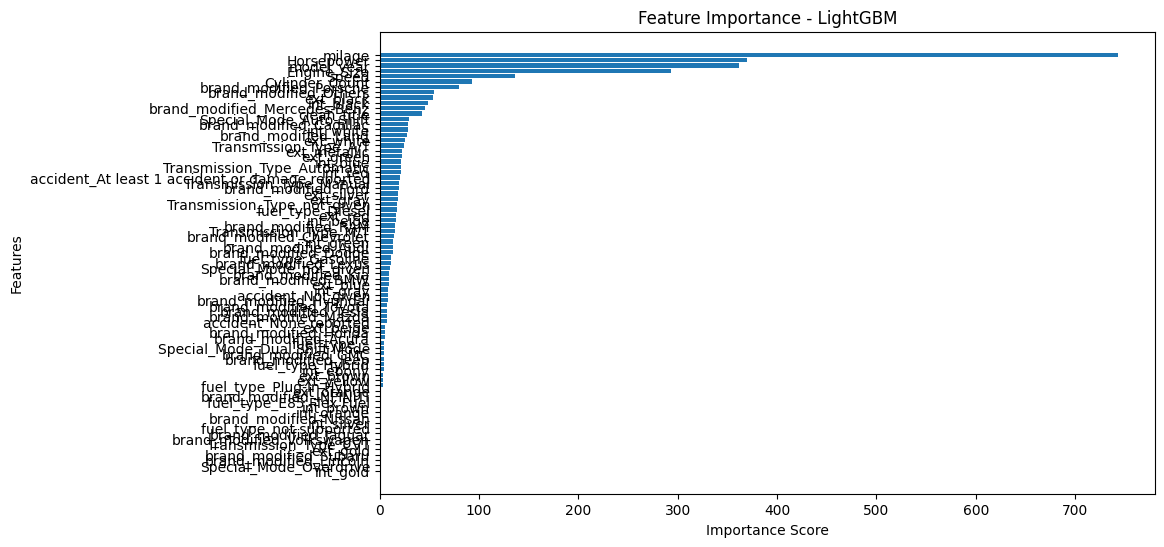

In [252]:
feature_importances = model.feature_importances_

# Step 3: Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Step 4: Display the feature importance DataFrame
print(feature_importance_df)

feature_importance_df.to_csv("ft_lgbm.csv", index=False)

# Step 5: Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Feature Importance - LightGBM')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [253]:
unimportant_feature_importance_df = feature_importance_df[feature_importance_df["Importance"] == 0]
unimportant_feature_importance_df

,Feature,Importance
22,int_silver,0
63,fuel_type_not supported,0
42,brand_modified_Jaguar,0
57,brand_modified_Volkswagen,0
71,Transmission_Type_CVT,0
13,ext_gold,0
54,brand_modified_Subaru,0
47,brand_modified_Lincoln,0
77,Special_Mode_Overdrive,0
26,int_gold,0


as we can see, there are several columns that has 0 importance value. Which means that this column contributes nothing for calculating the prices of the car. 
I think that I want to re-check each column to know that there is no any kind of error within the column

In [257]:
list_unimportant = unimportant_feature_importance_df["Feature"].tolist()

for x in list_unimportant:
    print(tr[x].value_counts())

int_silver
False    188104
True        429
Name: count, dtype: int64
fuel_type_not supported
False    188518
True         15
Name: count, dtype: int64
brand_modified_Jaguar
False    187214
True       1319
Name: count, dtype: int64
brand_modified_Volkswagen
False    186768
True       1765
Name: count, dtype: int64
Transmission_Type_CVT
False    186528
True       2005
Name: count, dtype: int64
ext_gold
False    186865
True       1668
Name: count, dtype: int64
brand_modified_Subaru
False    186152
True       2381
Name: count, dtype: int64
brand_modified_Lincoln
False    186110
True       2423
Name: count, dtype: int64
Special_Mode_Overdrive
False    188337
True        196
Name: count, dtype: int64
int_gold
False    188166
True        367
Name: count, dtype: int64


each of the value is free from error. I think that this is because of the fact that each of the column has low amount of true counts, and that is the reason behind they are not really meaningful

next, what can I see is that the brand "others" column has a significant impact to our model and calculation. Since I decided to make brand that has < 2000 model, it seems that brand that has low amount of cars, tend to has a higher prices. We need to check this

In [272]:

# Use .loc to filter the 'original' DataFrame based on these indexes

original = pd.read_csv("train.csv")

matching_indexes = tr[tr["brand_modified_Others"] == True].index

# Use .loc to filter the 'original' DataFrame based on these indexes
ori = original.loc[matching_indexes]
ori

31

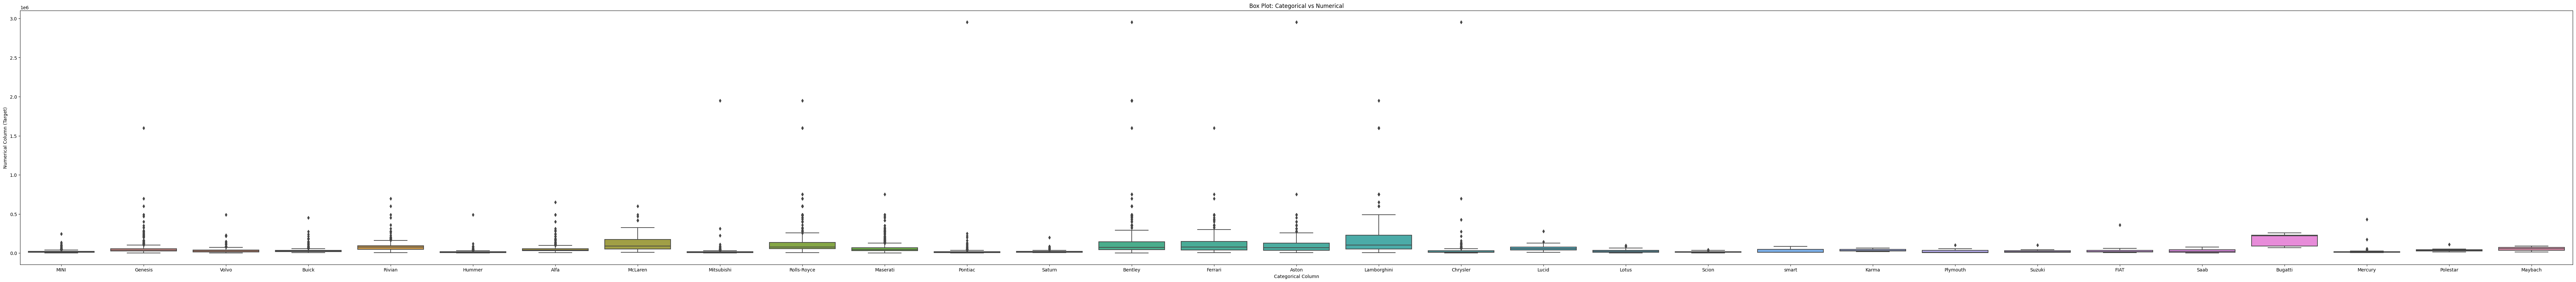

In [278]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 10))
sns.boxplot(x='brand', y='price', data=ori)
plt.title('Box Plot: Categorical vs Numerical')
plt.xlabel('Categorical Column')
plt.ylabel('Numerical Column (Target)')
plt.show()


what I found is that there is in fact several brands that are generally more expensive compared to other brands. The brands are: 
- 

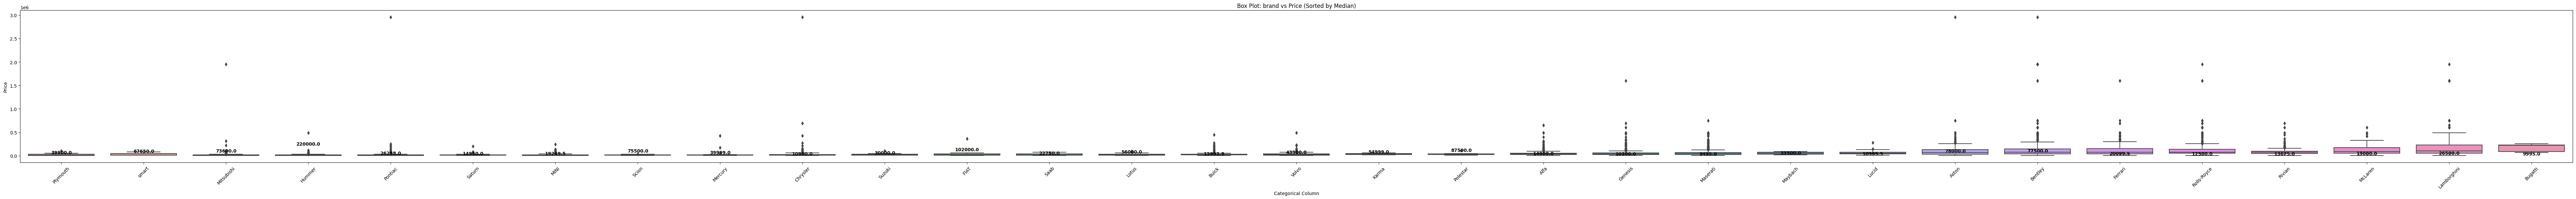

In [281]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df contains the 'categorical_column' and 'price'

# Calculate medians for sorting
medians = ori.groupby('brand')['price'].median().sort_values()

# Create a sorted boxplot
plt.figure(figsize=(100, 6))
sns.boxplot(x='brand', y='price', data=ori, order=medians.index)

# Add median lines for clarity
median_lines = ori.groupby('brand')['price'].median()
for i in range(len(median_lines)):
    plt.text(i, median_lines.iloc[i], round(median_lines.iloc[i], 2),
             horizontalalignment='center', color='black', weight='semibold')

plt.title('Box Plot: brand vs Price (Sorted by Median)')
plt.xlabel('Categorical Column')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()


From what I get, I want to divide the others column into this three different categories, so that I wish it will turn to be a better result. For big part, I might want to assign each car into one column.

others small
- Plymouth, smart, Mitsubishi, Hummer, Pontiac, Saturn, MINI, Scion, Mercury, Chrysler, Suzuki, FIAT, Saab

others medium
- Lotus, Buick, Volvo, Karma, Polestar, Alfa, Genesis, Maserati

big
- Maybach, Lucid, Aston, Bentley, Ferrari, Rolls-Royce, Rivian, McLaren, Lamborghini, Bugatti